In [ ]:
import cv2
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from astropy.io import fits
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line
from skimage import data
from timeit import default_timer as timer
from scipy.ndimage.filters import gaussian_filter
import numpy.ma as ma
import glob
import os
%matplotlib widget

In [4]:
#Directory where smaps of splitted images and full image is stored
dataset = 'snr2'
image_folder_smaps = '/lustre/fs23/group/icecube/azenin/last/images/last_streaks/last_' + dataset + '_part/'
image_folder_image = '/lustre/fs23/group/icecube/azenin/last/images/last_streaks/last_' + dataset + '_new.fit'
full_image_file = fits.open(image_folder_image)
full_image = full_image_file[0].data
#create empty mask for full image
mask = np.zeros((full_image.shape[0],full_image.shape[1]))
xmax, ymax = mask.shape
#properties of subimages and internal stuff
x_parts = 5
y_parts = 10
smap_file = fits.open(image_folder_smaps + 'last_' + dataset + '_x0y0_smap.fit')
smap = smap_file[0].data
cutoff_smaps = np.zeros((x_parts, y_parts, smap.shape[0], smap.shape[1]))
lines_sample = []
global_lines = []

In [24]:
#IMPORTANT: WE NEED PSF (in pixel size), 
psf=1.5

In [29]:
#Load smaps from splitted input image, calculate cutoff
line_array = np.zeros((x_parts, y_parts, 2))
for i in range(x_parts):
    for j in range(y_parts):
        filename = image_folder_smaps + 'last_' + dataset + '_x%d' % i + 'y%d' % j + '_smap.fit' 
        with fits.open(filename) as hdul:
            image=hdul[0].data
            image[np.isnan(image)] = 0
            histogram = image.flatten()
            """
            plt.hist(histogram, 100)
            plt.xlim(0,10)
            plt.yscale('log')
            """
            try:
                histogram=histogram[histogram < 0]
                quantile = np.quantile(histogram, 0.32)
            except:
                quantile = 0
            cutoff = abs(quantile)
            image[image < cutoff] = 0
            cutoff_smaps[i][j] = image
            """
            plt.imshow(image, cmap='gray')
            plt.colorbar()
            plt.show()
            """

In [42]:
global_lines = []
#Do canny and hough for line finding
# Anatolii:
# Changed this part to make it append global lines instead 
for i in range(cutoff_smaps.shape[0]):
    for j in range(cutoff_smaps.shape[1]):
        start2 = timer()
        #edges = canny(cutoff_smaps[i][j], 5*psf, 0.8)
        lines = list(probabilistic_hough_line(cutoff_smaps[i][j], threshold=0, line_length=int(15*psf), line_gap=int(1*psf)))
        for k in range(len(lines)):
            xd=lines[k][0][0]-lines[k][1][0]
            yd=lines[j][0][1]-lines[j][1][1]
            dist = np.sqrt(np.power(xd, 2) + np.power(yd, 2))
            if dist < 30*psf:
#                 print('line is too short')
                continue
            lines[k] = list(lines[k])
            lines[k][0] = list(lines[k][0])
            lines[k][1] = list(lines[k][1])
            lines[k][0][0] += j*smap.shape[1]
            lines[k][1][0] += j*smap.shape[1]
            lines[k][0][1] += i*smap.shape[0]
            lines[k][1][1] += i*smap.shape[0]
#             print("modified: %d, %d; i = %d, j = %d" % (lines[k][0][0], lines[k][0][1], i, j))
#             if(lines[k][0][0] < (i+1) * smap.shape[0] and lines[k][0][1] < (j+1) * smap.shape[1] and lines[k][1][0] < (i+1) * smap.shape[0] and lines[k][1][1] < (j+1) * smap.shape[1]):
            global_lines.append(lines[k])
print(len(global_lines))
#output is list of arrays, where start and end-points of found lines are listed
#not a list of tuples or lists?

536


In [94]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(full_image, cmap=cm.gray, norm=LogNorm())
ax[0].set_title('Input image')

ax[1].imshow(full_image * 0)
for line in global_lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
#ax[1].set_xlim((0,full_image.shape[1]))
#ax[1].set_ylim((full_image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#Here we need the code to get the global coordinates for the found lines in lines_sample
# line_array = np.zeros((x_parts, y_parts, 2))
# for i in range(x_parts):
#     for j in range(y_parts):
#         line_array[i][j][0] = lines[i*y_parts+j][0]
#         line_array[i][j][1] = lines[i*y_parts+j][1]
#Output should be an list of all global line coordinates (global_lines)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [97]:
mask = np.zeros((full_image.shape[0],full_image.shape[1]))
#Get with start and end point of lines from hough all touching array cells
#HERE IS A FUCKING ERROR, THERE IS SOME SHIFT IN X DIRECTION OF THE LINES
def draw_line(mat, y0, y1, x0, x1, inplace=True):
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
    if not inplace:
        mat = mat.copy()
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 1
        return mat if not inplace else None
    # Write line ends
    mat[x0, y0] = 1
    mat[x1, y1] = 1
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    xs=x1-x0
    ys=y1-y0
    if (xs != 0):
        y = np.round(ys/xs * (x - x0) + y0).astype(x.dtype)
    else:
        return
    # Write intermediate coordinates
    mat[x, y] = 1
    if not inplace:
        return mat if not transpose else mat.T

    
#Here we need global_lines from the missing part before
#Place lines in the empty mask
for line in global_lines:
    p0, p1 = line
#     if (p0[1] < xmax and p1[1] < ymax and p0[0] < xmax and p1[0] < ymax):
    draw_line(mask, p0[0], p1[0], p0[1], p1[1])

In [102]:
#Fold mask with gaussian to get line width (PSF-based)
%matplotlib widget
mask = gaussian_filter(mask, sigma=int(3*psf))
mask[mask > 0.] = 1
#Get masked image
masked_image = ma.masked_where(mask >0, full_image)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(masked_image, norm=LogNorm())
ax[0].set_title("masked image")
# plt.show()
ax[1].imshow(full_image, norm=LogNorm())
# plt.colorbar()
ax[1].set_title("input image")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

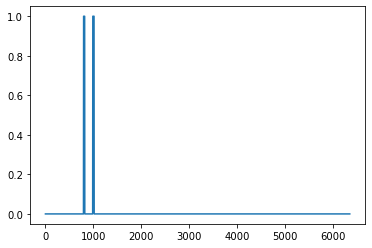

In [61]:
# plt.imshow(mask)
%matplotlib inline
plt.plot(mask[0, :])
plt.show()

In [13]:
plt.imshow(cutoff_smaps[1][1])
plt.colorbar()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
full_smap_file = fits.open("/lustre/fs23/group/icecube/azenin/last/images/snr2_smap.fit")
full_smap = full_smap_file[0].data
image = full_smap
histo = image.flatten()
try:
    histo=histo[histogram < 0]
    quantile = np.quantile(histo, 0.32)
except:
    quantile = 0
cutoff = abs(quantile)
image[image < cutoff] = 0
plt.imshow(image)
plt.colorbar()
plt.show()


In [105]:
### efficiency metric
# make an expectation array with known streak parameters
# streak in images (x = ay + b):
a = 0
b = 1000
im_w = full_image.shape[0]
im_h = full_image.shape[1]
expectation_mask = np.zeros((im_w, im_h))
inv_expectation_mask = np.ones((im_w, im_h))
inv_mask = np.ones((im_w, im_h))
width = psf * 3

def widthfun(x):
    if (abs(x) <= width):
        return 1.
    else:
        return 0.

def AddMask(image, a = 0.5, b = 0, start = 0, end = -1, width = 2):
    if end == -1:
        end = im_w;
    if np.absolute(a) >= 1:
        for i in range(start, end):
            for j in range(math.ceil(np.absolute(a))): # to avoid line breaks when a > 1
                if(int(a * i + b) + j > 0 and int(a * i + b) + j < im_h):
                    image[i][int(a * i + b) + j] = 1.
            for k in range(math.ceil(np.absolute(a)), 3*width):
                if(int(a * i + b) + k > 0 and int(a * i + b) + k < im_h):
                    image[i][int(a * i + b) + k] += widthfun(k * np.cos(np.arctan(a)))

            for k in range(-3*int(np.ceil(width/2)), 0):
                if(int(a * i + b) + k  > 0 and int(a * i + b) + k < self.im_h):
                    image[i][int(a * i + b) + k] += widthfun(k * np.cos(np.arctan(a)))

    if np.absolute(a) < 1:
        for i in range(start, end):
            # for j in range(math.ceil(np.absolute(1/a))): # to avoid line breaks when 1/a > 1
            if(int(a * i + b) > 0 and int(a * i + b) < im_h):
                image[i][int(a * i + b)] += 1.
                    # b_n = int(a * i + b) + j - int(a_n * i)

            for k in range(1, 3*int(np.ceil(width/2))):
                if(int(a * i + b) + k > 0 and int(a * i + b) + k < im_h):
                    image[i][int(a * i + b) + k] += widthfun(k * np.cos(np.arctan(a)))
            for k in range(-3*int(np.ceil(width/2)), 0):
                if(int(a * i + b) + k  > 0 and int(a * i + b) + k < im_h):
                    image[i][int(a * i + b) + k] +=widthfun(k * np.cos(np.arctan(a)))
                    
AddMask(expectation_mask, a, b, width = width)
inv_expectation_mask -= expectation_mask
inv_mask -= mask
# compare with the result
targetpos = np.count_nonzero(expectation_mask > 0.1)
targetneg = np.count_nonzero(inv_expectation_mask > 0.1)
truepos = np.sum(mask[expectation_mask > 0.1])
falsepos = np.sum(mask[expectation_mask < 0.1])
efficiency_tp = truepos / targetpos
efficiency_fn = falsepos / targetneg 
print(efficiency_tp)
print(efficiency_fn)

0.6112155388471178
0.016294084304535966


In [17]:
plt.imshow(expectation_mask)
plt.colorbar()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …